In [11]:
%pylab inline
%matplotlib inline
import pandas as pd
import json
import seaborn
import boto
import matplotlib.pyplot as plt
import numpy as np
import os, fnmatch

from IPython.core.display import HTML

css ="""
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}"""

HTML('<style>{}</style>'.format(css))

Populating the interactive namespace from numpy and matplotlib


/Users/mkjaiswa/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Loading Tags.json file that contains  features for each sensors.

In [12]:
df_tags = pd.read_json('tags.json')
df_tags_by_rows = df_tags.T
df_tags_by_rows.head(2)

,contexts,name,network,paging,sensorpoints,template,total,uri
000581ec-54ef-4a5f-ae10-706817b7efe3,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",Average Supply Flow EBU3B RM-3xxx,BACNET,"{u'limit': 1000, u'offset': 0}","[{u'from_template': True, u'update_period': 0,...",Average Supply Flow,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...
00138452-8623-11e3-9443-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",UCSD-Main-EBU3B-3250-Damper Position-Unreliabl...,Fault Detection,"{u'limit': 1000, u'offset': 0}","[{u'from_template': False, u'update_period': N...",Unreliable Sensor,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...


###  Load  processed sensor data files from S3 bucket.

In [13]:
targetdir = 'data'

filelist = fnmatch.filter(os.listdir(targetdir), '*.json')
df_json  = pd.DataFrame()

for f in filelist:
    f = targetdir +'/'+ f
    df = pd.read_json(f,orient='split')
    df_json = df_json.append(df,ignore_index=True)
    
df_template = pd.DataFrame(pd.DataFrame(df_tags.T['template'].reset_index()))
df_json_temp = pd.merge(df_json,df_template,left_on='sensor_id',right_on='index')[['sensor_id','template','room','values','sensor_value']]

###  Visualize  Sensor , room level values

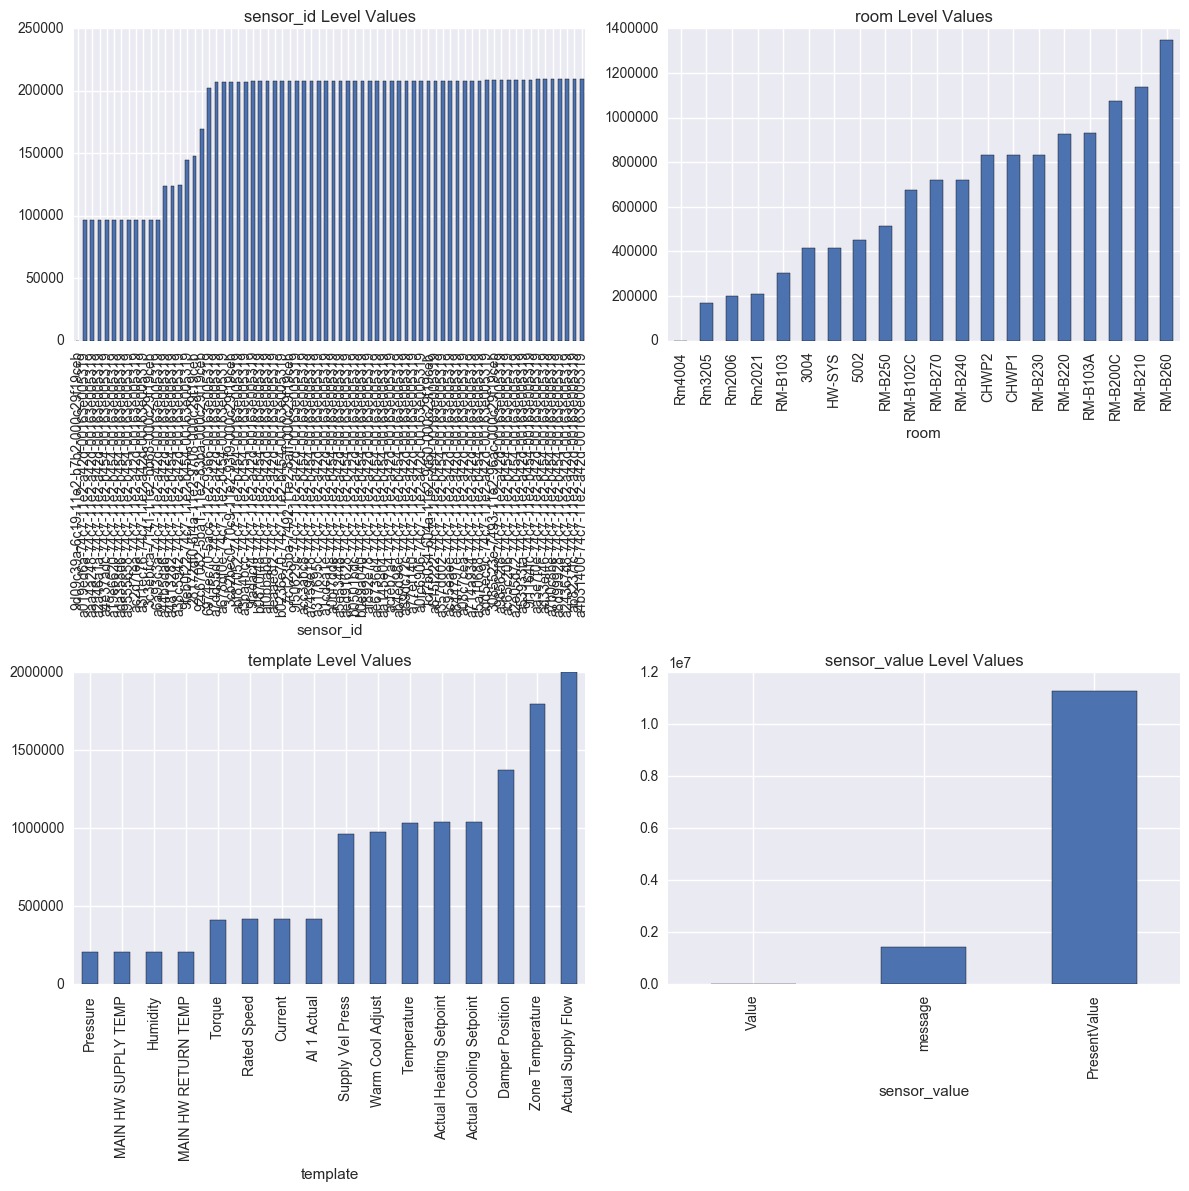

In [14]:
fig, axes = plt.subplots(figsize=(12,12),nrows=2, ncols=2)
df_plt = df_json_temp[['sensor_id','values']].groupby(['sensor_id']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('sensor_id'),legend=False,ax=axes[0,0])     
df_plt = df_json_temp[['room','values']].groupby(['room']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('room'),legend=False,ax=axes[0,1])     
df_plt = df_json_temp[['template','values']].groupby(['template']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('template'),legend=False,ax=axes[1,0])     
df_plt = df_json_temp[['sensor_value','values']].groupby(['sensor_value']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('sensor_value'),legend=False,ax=axes[1,1])     
plt.tight_layout()

In [15]:
df_tags_by_rows.head(2)

,contexts,name,network,paging,sensorpoints,template,total,uri
000581ec-54ef-4a5f-ae10-706817b7efe3,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",Average Supply Flow EBU3B RM-3xxx,BACNET,"{u'limit': 1000, u'offset': 0}","[{u'from_template': True, u'update_period': 0,...",Average Supply Flow,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...
00138452-8623-11e3-9443-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",UCSD-Main-EBU3B-3250-Damper Position-Unreliabl...,Fault Detection,"{u'limit': 1000, u'offset': 0}","[{u'from_template': False, u'update_period': N...",Unreliable Sensor,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...


### Getting name of the Sensors

In [16]:
df_tags_by_rows.name.str.split('-').map(lambda x:x[-1]).head(5)

000581ec-54ef-4a5f-ae10-706817b7efe3                 3xxx
00138452-8623-11e3-9443-00163e005319    Unreliable Sensor
0017902c-74c9-11e2-b454-00163e005319     Occupied Command
001a5e8e-77de-11e2-bad4-00163e005319     Supply Vel Press
001b6972-77df-11e2-83c4-00163e005319     Warm/Cool Adjust
Name: name, dtype: object

In [17]:
df_tags_by_rows.head(2)

,contexts,name,network,paging,sensorpoints,template,total,uri
000581ec-54ef-4a5f-ae10-706817b7efe3,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",Average Supply Flow EBU3B RM-3xxx,BACNET,"{u'limit': 1000, u'offset': 0}","[{u'from_template': True, u'update_period': 0,...",Average Supply Flow,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...
00138452-8623-11e3-9443-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",UCSD-Main-EBU3B-3250-Damper Position-Unreliabl...,Fault Detection,"{u'limit': 1000, u'offset': 0}","[{u'from_template': False, u'update_period': N...",Unreliable Sensor,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...


###  Creating a seperate dataframe for context for flatening JSON

In [18]:
dict_col = df_tags_by_rows.pop('contexts')
df_contexts = pd.DataFrame(dict_col)
df_contexts.head(2)

,contexts
000581ec-54ef-4a5f-ae10-706817b7efe3,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':..."
00138452-8623-11e3-9443-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':..."
0017902c-74c9-11e2-b454-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':..."
001a5e8e-77de-11e2-bad4-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':..."
001b6972-77df-11e2-83c4-00163e005319,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':..."


### Further flatening the inner JSON Object and concating with outer object.

In [20]:
dict_col = df_contexts.pop('contexts')
df_contexts = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_contexts = pd.DataFrame(df_contexts.stack())
df_contexts.head()

0
000581ec-54ef-4a5f-ae10-706817b7efe3 0  {u'tag': u'EBU3B', u'id': 155971, u'keyword': ...
                                     1  {u'tag': u'Main', u'id': 2, u'keyword': u'camp...
                                     2  {u'tag': u'Flr-3', u'id': 156189, u'keyword': ...
                                     3  {u'tag': u'UCSD', u'id': 1, u'keyword': u'inst...
                                     4  {u'tag': u'RM-3xxx', u'id': 157430, u'keyword'...

### Rename column with inner and then again flatten the inner and concat with outer.

In [23]:

df_contexts.columns = ['inner']
dict_col = df_contexts.pop('inner')
df_contexts = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_contexts_flat = df_contexts.reset_index()

df_contexts_flat.head(5)

,level_0,level_1,id,keyword,tag,uri
0,000581ec-54ef-4a5f-ae10-706817b7efe3,0,155971,building,EBU3B,/admin/api/contexts/155971
1,000581ec-54ef-4a5f-ae10-706817b7efe3,1,2,campus,Main,/admin/api/contexts/2
2,000581ec-54ef-4a5f-ae10-706817b7efe3,2,156189,floor,Flr-3,/admin/api/contexts/156189
3,000581ec-54ef-4a5f-ae10-706817b7efe3,3,1,institution,UCSD,/admin/api/contexts/1
4,000581ec-54ef-4a5f-ae10-706817b7efe3,4,157430,room,RM-3xxx,/admin/api/contexts/157430


## Counts of each keywords

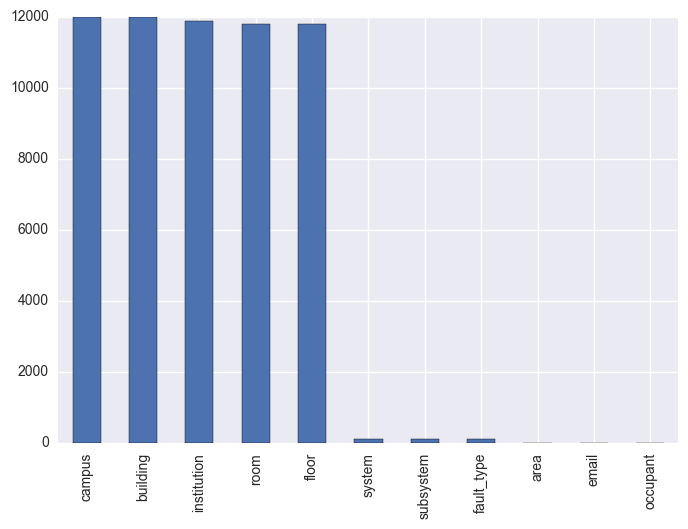

In [10]:
df_contexts_flat.keyword.value_counts().plot(kind='bar')

# Summarize Sensor points.

In [11]:
dict_col = df_tags_by_rows.pop('sensorpoints')
df_sensorpoints = pd.DataFrame(dict_col)

dict_col = df_sensorpoints.pop('sensorpoints')
df_sensorpoints = pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)
df_sensorpoints = pd.DataFrame(df_sensorpoints.stack())


df_sensorpoints.columns = ['sensor_inner']
dict_col = df_sensorpoints.pop('sensor_inner')
df_sensorpoints = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_sensorpoints_flat = df_sensorpoints.reset_index()

dict_col = df_sensorpoints_flat.pop('timeseries_span')
df_sensorpoints_flat = pd.concat([df_sensorpoints_flat, dict_col.apply(pd.Series)], axis=1)

In [12]:
df_sensorpoints_flat.head(2)

,level_0,level_1,id,keyword,tag,uri,active,created_time,data_type,description,...,readonly,shorthand_unit,timeseries_type,type,unit,update_period,uri,0,begin,end
0,000581ec-54ef-4a5f-ae10-706817b7efe3,0,155971.0,building,EBU3B,/admin/api/contexts/155971,True,2014-08-19T20:56:32+00:00,int,PresentValue,...,False,None,continuous,PresentValue,None,0.0,/admin/api/sensors/000581ec-54ef-4a5f-ae10-706...,NaN,2014-08-19T20:56:32+00:00,2015-12-23T02:18:43+00:00
1,000581ec-54ef-4a5f-ae10-706817b7efe3,1,2.0,campus,Main,/admin/api/contexts/2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Counts of  rooms , buildings and sensors.

In [13]:
cnt_sensor = len(df_sensorpoints_flat.level_0.unique())
cnt_room= df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'room'].nunique()
cnt_bldg= df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'building'].nunique()
df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'institution'].unique()

array([u'UCSD', u'Test_Institution', u'Bizwack Institute'], dtype=object)

In [14]:
df_data = pd.DataFrame({'no_of_sensor':[cnt_sensor],'no_of_room':[cnt_room],'no_of_building':[cnt_bldg]})
df_data

,no_of_building,no_of_room,no_of_sensor
0,7,734,11992


# Contexts

In [15]:
dict_col = df_sensorpoints.pop('timeseries_span')
pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

dict_col = df_sensorpoints.pop('latest_datapoint')
pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

#pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

df_tags.iloc[[5]].T.head(5)

,template
000581ec-54ef-4a5f-ae10-706817b7efe3,Average Supply Flow
00138452-8623-11e3-9443-00163e005319,Unreliable Sensor
0017902c-74c9-11e2-b454-00163e005319,Occupied Command
001a5e8e-77de-11e2-bad4-00163e005319,Supply Vel Press
001b6972-77df-11e2-83c4-00163e005319,Warm Cool Adjust


In [16]:
# df1 = pd.read_json('data/DF_00_split3.json', orient = 'split')
# df2 = pd.read_json('data/DF_00_split1.json', orient ='split')

In [17]:
# df_1 = pd.read_json('data/DF_00_split0.json', orient='split')
# df_2 = pd.read_json('data/DF_00_split3.json', orient='split')
# df_3 = pd.read_json('data/DF_00_split4.json', orient='split')
# df_4 = pd.read_json('data/DF_00_split5.json', orient='split')
# df_5 = pd.read_json('data/DF_00_split6.json', orient='split')

In [18]:
#df_all = pd.concat([df_1, df_2, df_3, df_4, df_5])
df_json_temp.head()

,sensor_id,template,room,values,sensor_value
0,9f50629c-74c7-11e2-a42d-00163e005319,MAIN HW SUPPLY TEMP,HW-SYS,179.75,PresentValue
1,9f50629c-74c7-11e2-a42d-00163e005319,MAIN HW SUPPLY TEMP,HW-SYS,144.88,PresentValue
2,9f50629c-74c7-11e2-a42d-00163e005319,MAIN HW SUPPLY TEMP,HW-SYS,173.13,PresentValue
3,9f50629c-74c7-11e2-a42d-00163e005319,MAIN HW SUPPLY TEMP,HW-SYS,162.63,PresentValue
4,9f50629c-74c7-11e2-a42d-00163e005319,MAIN HW SUPPLY TEMP,HW-SYS,170.5,PresentValue


In [41]:
#temp = df_json_temp['values']
#mask = temp.str.contains('{').isnull()
#temp[temp.str.contains('{').isnull()]

In [1]:
#temp[mask].astype('float')

In [2]:
#df_json_temp['values'].hist(bins=20)

In [ ]:
#(df2['values'] < 0).sum() *1.0 / df2.sensor_value.count()